In [0]:
from sklearn.datasets import load_files  
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import nltk
from nltk import WhitespaceTokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.utils import resample
from keras.models import Sequential

In [0]:
# download the dataset
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
!tar xzf review_polarity.tar.gz

--2020-03-10 19:07:13--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  1.43MB/s    in 2.1s    

2020-03-10 19:07:16 (1.43 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



In [0]:
# load the dataset
movies = load_files("txt_sentoken", encoding="utf-8")  
x, y = movies.data, movies.target

In [0]:
nltk.download('stopwords')
# tokenize the sentences
whitespace_wt = WhitespaceTokenizer()
sentences_tokenized = []
for sent in x:
    sent_tok = whitespace_wt.tokenize(sent)
    sentences_tokenized.append(sent_tok)
# remove the stop words from the corpus
filtered = []
for words in sentences_tokenized:
      filtered.append([j for j in words if j not in stopwords.words('english')])
# stitch the tokens back to sentences
e = [" ".join(i) for i in filtered ]
# remove the punctuation , lower case all the words and tokenize with keras
tokenizer = Tokenizer(num_words=None,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,oov_token='__UNK__')
tokenizer.fit_on_texts(e)
x_ = tokenizer.texts_to_sequences(e)
vocab = len(tokenizer.word_index) + 1
max_length = max([len(x_[i]) for i in range(len(x_))])
# padd with zeros to create a uniform matrix
x_tokeniz = pad_sequences(x_, maxlen=max_length,padding='post')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# split the dataset into train and test set in ratio 9/1
x_train, x_test, y_train, y_test = train_test_split(x_tokeniz, y, test_size=0.1, random_state=8888)
# split the dataset into train and developement set
x_train, x_dev, y_train, y_dev = train_test_split(x_train, y_train, test_size=0.1, random_state=8888)

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2020-03-06 11:29:26--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.20.22.166, 104.20.6.166, 2606:4700:10::6814:6a6, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.20.22.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  11.7MB/s    in 1m 49s  

2020-03-06 11:31:16 (11.6 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [0]:
word_index = tokenizer.word_index
# Get the words of our vocabulary
vocab_words = list(word_index.keys())

embeddings_index = {}

with open("cc.en.300.vec", "r", encoding="utf-8", newline="\n",errors="ignore") as f:
  for l in tqdm(f):
    values = l.split()
    if len(values) == 2:
      embedding_dim = int(values[1])
    else:
      word = values[0]
      embeddings_index[word] = np.array(values[1:]).astype(np.float)

2000001it [06:45, 4934.84it/s]


In [0]:
embedding_matrix = np.zeros((vocab, embedding_dim))
for word in tqdm(vocab_words):
  try:
    index = word_index[word]
    embedding_matrix[index] = embeddings_index[word]
  except:
    pass

100%|██████████| 43266/43266 [00:00<00:00, 360251.16it/s]


In [0]:
np.save("embedding_matrix.npy", embedding_matrix, allow_pickle=True)

In [0]:
# load the pretrained word embeddings
embedding_matrix = np.load("/content/drive/My Drive/Colab Notebooks/embedding_matrix.npy")
embedding_dim = len(embedding_matrix[1])

In [0]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [0]:
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers.core import Layer

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class LinearAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, bias_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.b_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(LinearAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        
        # eij = Wx + b
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        # a = softmax(eij)
        a = K.expand_dims(K.softmax(eij, axis=-1))
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]


class DeepAttention(Layer):
    def __init__(self,
                 kernel_regularizer=None, u_regularizer=None, bias_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b1_regularizer = regularizers.get(bias_regularizer)
        self.b2_regularizer = regularizers.get(bias_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b1_constraint = constraints.get(b_constraint)
        self.b2_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.return_attention = return_attention
        super(DeepAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b1 = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b1'.format(self.name),
                                     regularizer=self.b1_regularizer,
                                     constraint=self.b1_constraint)
            self.b2 = self.add_weight((1,),
                                     initializer='zero',
                                     name='{}_b2'.format(self.name),
                                     regularizer=self.b2_regularizer,
                                     constraint=self.b2_constraint)
        else:
            self.b1 = None
            self.b2 = None

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        self.built = True


    def compute_mask(self, inputs, mask=None):
        # do not pass the mask to the next layers
        if self.return_attention:
            return [None, None]
        return None

    def call(self, x, mask=None):
        # uit = tanh(Wx + b)
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b1

        uit = K.tanh(uit)

        # ait = softmax(Ueij)
        eij = dot_product(uit, self.u)
        if self.bias:
            eij += self.b2

        # Apply mask
        if mask is not None:
            eij *= K.cast(mask, K.floatx())

        a = K.expand_dims(K.softmax(eij, axis=-1))
        
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [0]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.layers import Dense, Dropout, Bidirectional, Input
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

LSTM_SIZE = 100
DENSE = 150
N_CLASSES = 1

inputs = Input((max_length,))
embeddings = Embedding(vocab,embedding_dim, weights=[embedding_matrix], 
                    input_length=max_length, mask_zero=True, trainable=False)(inputs)
drop_emb = Dropout(0.5)(embeddings)
bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = 0.2))(drop_emb)
bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = 0.3))(bilstm)
# x, attn = LinearAttention(return_attention=True)(bilstm)
x, attn = DeepAttention(return_attention=True)(bilstm)
out = Dense(units=DENSE, activation="relu")(x) 
out = Dense(units=N_CLASSES, activation="sigmoid")(out)
model = Model(inputs, out)

print(model.summary())
model.compile(loss='binary_crossentropy',
                  optimizer=Adam(lr=0.0001),
                  metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_BiLSTM+attn_model', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)

history = model.fit(x_train, y_train,
              batch_size=200,
              epochs=100,
              verbose = 2,
              callbacks=[checkpoint,early_stop],
              validation_data=(x_dev,y_dev),
              shuffle=True)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1410)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1410, 300)         12980100  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1410, 300)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1410, 200)         320800    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1410, 200)         240800    
_________________________________________________________________
deep_attention_2 (DeepAttent [(None, 200), (None, 1410 40401     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               3015

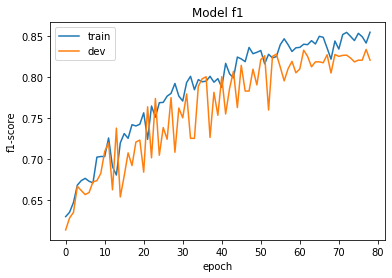

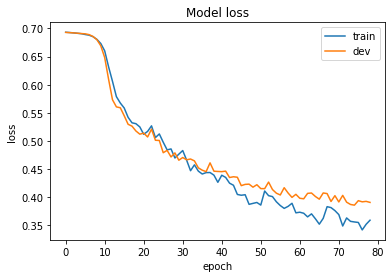

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for f1
plt.plot(history.history['f1'])
plt.plot(history.history['val_f1'])
plt.title('Model f1')
plt.ylabel('f1-score')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.show()

In [0]:
# predict neural network in train set
predictions_nn_train = model.predict(np.array(x_train))
# threshold used t=0,5 (round())
print("Classification report for Neural network in train :\n",metrics.classification_report(y_train,np.round(predictions_nn_train)))
predictions_nn_dev = model.predict(np.array(x_dev))
# threshold used t=0,5 (round())
print("Classification report for Neural network in dev :\n",metrics.classification_report(y_dev,np.round(predictions_nn_dev)))
predictions_nn_test = model.predict(np.array(x_test))
# threshold used t=0,5 (round())
print("Classification report for Neural network in test :\n",metrics.classification_report(y_test,np.round(predictions_nn_test)))

Classification report for Neural network in train :
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       809
           1       0.92      0.88      0.90       811

    accuracy                           0.90      1620
   macro avg       0.90      0.90      0.90      1620
weighted avg       0.90      0.90      0.90      1620

Classification report for Neural network in dev :
               precision    recall  f1-score   support

           0       0.84      0.82      0.83        93
           1       0.81      0.83      0.82        87

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.82       180
weighted avg       0.82      0.82      0.82       180

Classification report for Neural network in test :
               precision    recall  f1-score   support

           0       0.83      0.85      0.84        98
           1       0.85      0.83      0.84       102

    accuracy              

In [0]:
print('F1 score with macro averaging in train set',f1_score(y_train,np.round(predictions_nn_train),average='macro'))
print('F1 score with macro averaging in dev set',f1_score(y_dev,np.round(predictions_nn_dev),average='macro'))
print('F1 score with macro averaging in test set',f1_score(y_test,np.round(predictions_nn_test),average='macro'))

F1 score with macro averagin in train set 0.8999656946826757
F1 score with macro averagin in dev set 0.8221343873517787
F1 score with macro averagin in test set 0.8399839983998401


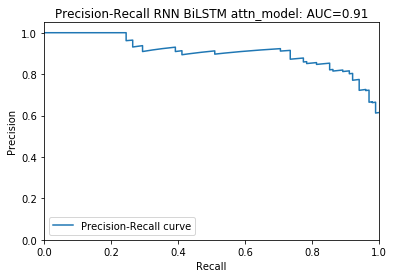

In [0]:
name ="RNN BiLSTM attn_model"
# compute precesion,recall for various thresholds
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, predictions_nn_test)
# compute the area under curve
area_nn = auc(recall_nn, precision_nn)


# plot the AUC curve for MLP
plt.plot(recall_nn, precision_nn, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' %(name,area_nn))
plt.legend(loc="lower left")
plt.show()

In [0]:
#  build mlp model to tune the hyperparameters
def create_model(optimizer="adam", dropout=0.2, dense_nparams=256):
    inputs = Input((max_length,))
    embeddings = Embedding(vocab,embedding_dim, weights=[embedding_matrix], 
                        input_length=max_length, mask_zero=True, trainable=False)(inputs)
    drop_emb = Dropout(dropout)(embeddings)
    bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = dropout))(drop_emb)
    bilstm = Bidirectional(LSTM(units=LSTM_SIZE, return_sequences=True,recurrent_dropout = dropout))(bilstm)
    #x, attn = LinearAttention(return_attention=True)(bilstm)
    x, attn = DeepAttention(return_attention=True)(bilstm)
    out = Dense(units=dense_nparams, activation="relu")(x) 
    out = Dense(units=N_CLASSES, activation="sigmoid")(out)
    model2 = Model(inputs, out)
    model2.compile(loss='binary_crossentropy',
                  optimizer=optimizer,metrics=[precision, recall, f1, accuracy])
    return model2

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
mymodel = KerasClassifier(build_fn=create_model, verbose=2)
# create a pipeline of the hyperparameter
lr_pipeline = Pipeline([
    ('kc', mymodel)])
grid_params = {
    'kc__epochs': [20],
    'kc__dense_nparams': [512,700],
    'kc__dropout': [0.3,0.5,],
    'kc__batch_size':[128,64],
    }

In [0]:
from sklearn.model_selection import RandomizedSearchCV
# random grid search 
clf2 = RandomizedSearchCV(lr_pipeline, grid_params,verbose=2,cv=3)
clf2.fit(x_train,y_train)
print("Best Score: ", clf2.best_score_)
print("Best Params: ", clf2.best_params_)

In [0]:
from keras.layers import GlobalAveragePooling1D

model_mlp = Sequential()
model_mlp.add(Embedding(vocab,embedding_dim, weights=[embedding_matrix], 
                    input_length=max_length, mask_zero=True, trainable=False))
model_mlp.add(GlobalAveragePooling1D())
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(300, activation='tanh'))
model_mlp.add(Dropout(0.2))
model_mlp.add(Dense(200,  activation='tanh'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(1,  activation='sigmoid'))

print(model_mlp.summary())
model_mlp.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001), metrics=[precision, recall, f1, accuracy])
# monitor loss in validation set and save the minimum values
checkpoint = ModelCheckpoint('kerasfastex', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
# monitor loss in validatin set and stop when starting to grow to avoid overfitting
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)
history_mlp = model_mlp.fit(x_train,y_train,
              batch_size=200,
              epochs=100,
              verbose = 2,
              callbacks=[early_stop, checkpoint],
              validation_data=(x_dev,y_dev),
              shuffle=True)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1410, 300)         12980100  
_________________________________________________________________
global_average_pooling1d_1 ( (None, 300)               0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 300)               90300     
_________________________________________________________________
dropout_30 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 200)               60200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 200)             

In [0]:
predictions_mlp_train = model_mlp.predict(np.array(x_train))
print('F1 score with macro averaging in train set for mlp',f1_score(y_train,np.round(predictions_mlp_train),average='macro'))
predictions_mlp_dev = model_mlp.predict(np.array(x_dev))
print('F1 score with macro averaging in dev set for mlp',f1_score(y_dev,np.round(predictions_mlp_dev),average='macro'))
predictions_mlp_test = model_mlp.predict(np.array(x_test))
print('F1 score with macro averaging in test set for mlp',f1_score(y_test,np.round(predictions_mlp_test),average='macro'))

F1 score with macro averaging in train set for mlp 0.8226902616933702
F1 score with macro averaging in dev set for mlp 0.7833266458841321
F1 score with macro averaging in test set for mlp 0.7938403519798869


In [0]:
# H0 RNN perfoms as good as MLP : F1_NN = F1_MLP
# H1 RNN performs better than MLP : F1_NN > F1_MLP

# n: lenght of test set
n = np.array(x_test).shape[0]
# b: samples draws
b = 1000
# the difference between F1 score of RNN and MLP 
delta = f1_score(y_test,np.round(predictions_nn_test),average="macro") - f1_score(y_test,np.round(predictions_mlp_test),average="macro")
count = 0
for i in range(b):
  # draw random samples with replacement from the test sets  
    x,y = resample(np.array(x_test),np.array(y_test), n_samples=n)
    # in the random test sets predict the models
    RNN = model.predict(x)
    MLP = model_mlp.predict(x)
    # compute the difference in f1 scores in the random test samples
    diff = f1_score(np.round(RNN),y,average="macro") - f1_score(np.round(MLP),y,average="macro")
    if diff > 2*delta:
            count += 1
p_value = count/b
if p_value < 0.01:
    print("RNN performs better than MLP")
    print("p-value:",p_value)
else:
    print("RNN performs as good as MLP")
    print("p-value:",p_value)

In [0]:
import numpy as np
from scipy.stats import random_correlation
x = random_correlation.rvs((.5, .8, 1.2, 1.5,,5,6,7,8,9))

ValueError: ignored

In [0]:
from scipy import random, linalg
matrixSize = 10 
A = random.rand(matrixSize,matrixSize)
B = np.dot(A,A.transpose())
print('random positive semi-define matrix for today is', B)

random positive semi-define matrix for today is [[1.97464736 1.84568814 1.6407832  1.47624155 1.86605723 2.22168599
  1.20813387 2.18976976 1.55746027 2.20006908]
 [1.84568814 3.70644647 2.45019561 2.98102946 3.43282729 3.22294636
  2.52276776 2.88857325 1.96066929 3.6257779 ]
 [1.6407832  2.45019561 3.46630281 2.57948692 2.57210382 2.69572042
  2.0859285  3.13560641 2.23849957 3.17553761]
 [1.47624155 2.98102946 2.57948692 3.7435883  2.9176656  2.72328391
  2.46045536 3.02560236 2.13233858 3.16546986]
 [1.86605723 3.43282729 2.57210382 2.9176656  3.56705008 3.12180785
  2.36937822 3.05630922 2.2097847  3.39589002]
 [2.22168599 3.22294636 2.69572042 2.72328391 3.12180785 5.0449386
  3.21487546 3.4200839  2.26804351 3.34312871]
 [1.20813387 2.52276776 2.0859285  2.46045536 2.36937822 3.21487546
  2.56813751 2.37138234 1.46157804 2.63264539]
 [2.18976976 2.88857325 3.13560641 3.02560236 3.05630922 3.4200839
  2.37138234 3.96792392 2.5387595  3.55570104]
 [1.55746027 1.96066929 2.23849957